### Compositional analysis of the DMD Myeloid scRNA-Seq dataset using `milopy`
- **Developed by**: Christian Eger
- **Modified by**: Carlos Talavera-López
- **Edited by**: Srivalli Kolla
- **Talavera-López Lab - Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 03_06_2024
- **Last modified**: 03_06_2024

## Import statements and environment prep

In [1]:
import scvi
import rpy2
import numpy as np
import scanpy as sc
import pandas as pd
import pertpy as pt
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from pertpy.tools import Milo

/home/skolla/miniforge3/envs/milo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                 10.3.0
absl                NA
adjustText          1.1.1
arrow               1.3.0
arviz               0.18.0
asttokens           NA
attr                23.2.0
backcall            0.2.0
blitzgsea           NA
certifi             2024.02.02
cffi                1.16.0
chardet             5.2.0
charset_normalizer  3.3.2
chex                0.1.86
comm                0.1.2
contextlib2         NA
custom_inherit      2.4.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
decoupler           1.6.0
docrep              0.3.2
etils               1.9.0
executing           0.8.3
flax                0.8.4
fsspec              2024.5.0
h5py                3.11.0
idna                3.7
igraph              0.11.5
importlib_resources NA
ipykernel           6.29.3
jax                 0.4.28
jaxlib              0.4.28
jaxopt              NA
jedi              

## Data preparation

### Data loading

In [3]:
rpy2.robjects.numpy2ri.activate()

## Data preparation

### Data loading

In [4]:
adata = sc.read_h5ad("../../data/heart_mm_nuclei-23-0092_scANVI-Myeloid_states_ctl240502.raw.h5ad")
adata

AnnData object with n_obs × n_vars = 41716 × 16060
    obs: 'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment'
    var: 'gene_ids-DMD_immune-DMD', 'feature_types-DMD_immune-DMD', 'genome-DMD_immune-DMD', 'mt-DMD_immune-DMD', 'ribo-DMD_immune-DMD', 'n_cells_by_counts-DMD_immune-DMD', 'mean_counts-DMD_immune-DMD', 'pct_dropout_by_counts-DMD_immune-DMD', 'total_counts-DMD

### Data cleanup

In [5]:
adata.obs = adata.obs.rename(columns={'cell_type': 'cell_types'})
adata.obs

orig.ident Age_group  BMI COVID_severity  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
...                                      ...       ...  ...            ...   
TTTGGAGAGCGACTGA-1_2-MDX_MPC-1           NaN       NaN  NaN            NaN   
TTTGGAGAGGATAATC-1_2-MDX_MPC-1           NaN       NaN  NaN            NaN   
TTTGGAGTCTCGGCTT-1_2-MDX_MPC-1           NaN       NaN  NaN            NaN   
TTTGTTGAGATTCGAA-1_2-MDX_MPC-1           NaN       NaN  NaN            NaN   
TTTGTTGGTGATATAG-1_2-MDX_MPC-1           NaN       NaN  NaN            NaN   

                                  COVID_status Ethnicity Group  Sex  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
...                                        ...       ...   ...  ...   
TTTGGAGAGCGACTGA-1_2-MDX_MPC-1             NaN       NaN   NaN  NaN   
TTTGGAGAGGATAATC-1_2-MDX_MPC-1             NaN       NaN   NaN  NaN   
TTTGGAGTCTCGGCTT-1_2-MDX_MPC-1             NaN       NaN   NaN  NaN   
TTTGTTGAGATTCGAA-1_2-MDX_MPC-1             NaN       NaN   NaN  NaN   
TTTGTTGGTGATATAG-1_2-MDX_MPC-1             NaN       NaN   NaN  NaN   

                                  annotation_broad annotation_detailed  ...  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
...                                            ...                 ...  ...   
TTTGGAGAGCGACTGA-1_2-MDX_MPC-1                 NaN                 NaN  ...   
TTTGGAGAGGATAATC-1_2-MDX_MPC-1                 NaN                 NaN  ...   
TTTGGAGTCTCGGCTT-1_2-MDX_MPC-1                 NaN                 NaN  ...   
TTTGTTGAGATTCGAA-1_2-MDX_MPC-1                 NaN                 NaN  ...   
TTTGTTGGTGATATAG-1_2-MDX_MPC-1                 NaN                 NaN  ...   

                                  pct_counts_ribo percent_mt2 percent_chrY  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW             NaN         NaN          NaN   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW             NaN         NaN          NaN   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW             NaN         NaN          NaN   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW             NaN         NaN          NaN   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW             NaN         NaN          NaN   
...                                           ...         ...          ...   
TTTGGAGAGCGACTGA-1_2-MDX_MPC-1                NaN         NaN          NaN   
TTTGGAGAGGATAATC-1_2-MDX_MPC-1                NaN         NaN          NaN   
TTTGGAGTCTCGGCTT-1_2-MDX_MPC-1                NaN         NaN          NaN   
TTTGTTGAGATTCGAA-1_2-MDX_MPC-1                NaN         NaN          NaN   
TTTGTTGGTGATATAG-1_2-MDX_MPC-1                NaN         NaN          NaN   

                                  XIST-counts S_score G2M_score _scvi_batch  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW         NaN     NaN       NaN        28.0   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW         NaN     NaN       NaN        29.0   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW         NaN     NaN       NaN        30.0   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW         

## Neighborhood calculation

In [6]:
sc.pp.neighbors(adata, n_neighbors=150, use_rep="X_scANVI")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:00)


# MILO

## Setup milo

##### Steps

1. Initiate Milo object
2. Load data into milo

In [7]:
milo = pt.tl.Milo()
mdata = milo.load(adata)
mdata

MuData object with n_obs × n_vars = 41716 × 16060
  2 modalities
    rna:	41716 x 16060
      obs:	'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_types', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment'
      var:	'gene_ids-DMD_immune-DMD', 'feature_types-DMD_immune-DMD', 'genome-DMD_immune-DMD', 'mt-DMD_immune-DMD', 'ribo-DMD_immune-DMD', 'n_cells_by_counts-DMD_immune-DMD', 'mean_counts-DMD_immune-DMD', 'pct_dropout_by_counts-DMD_immune-DMD', 'total_counts-DMD_immune-DMD', 'vst.mean-MDX_MPC-DMD', 'vst.variance-MDX_MPC-DMD', 'vst.variance.expected-MDX_MPC-DMD', 'vst.variance.standardized-MDX_MPC-DMD', 'vst.variable-MDX_MPC-DMD', 'vst.mean-MDX_POOL_NEW-DMD', 'vst.variance-MDX_POOL_NEW-DMD', 'vst.variance.expected-MDX_POOL_NEW-DMD', 'vst.variance.standardized-MDX_POOL_NEW-DMD', 'vst.variable-MDX_POOL_NEW-DMD', 'vst.mean-MDX_MPC', 'vst.variance-MDX_MPC', 'vst.variance.expected-MDX_MPC', 'vst.variance.standardized-MDX_MPC', 'vst.variable-MDX_MPC', 'vst.mean-MDX_POOL_NEW', 'vst.variance-MDX_POOL_NEW', 'vst.variance.expected-MDX_POOL_NEW', 'vst.variance.standardized-MDX_POOL_NEW', 'vst.variable-MDX_POOL_NEW', 'name-pbmc_meyer'
      uns:	'C_scANVI_S1_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_source_colors', 'genotype_colors', 'hvg', 'neighbors', 'sample_colors', 'seed_labels_colors', 'umap'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
      obsp:	'distances', 'connectivities'
    milo:	0 x 0

## Define neighborhoods

In [8]:
milo.make_nhoods(mdata, prop=0.1)
adata.obsm["nhoods"]

/home/skolla/miniforge3/envs/milo/lib/python3.11/site-packages/pertpy/tools/_milo.py:186: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.5834203 4.3309298 3.834348  ... 1.5956491 1.4842806 1.5915262]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs["nhood_ixs_refined"] == 1, "nhood_kth_distance"] = k_distances


<41716x3206 sparse matrix of type '<class 'numpy.float32'>'
	with 876253 stored elements in Compressed Sparse Row format>

### Visualization of Neighborhood distribution

([<matplotlib.axis.XTick at 0x7f435a5a1950>,
 [Text(55.0, 0, '55'),
  Text(105.0, 0, '105'),
  Text(155.0, 0, '155'),
  Text(205.0, 0, '205'),
  Text(255.0, 0, '255'),
  Text(305.0, 0, '305'),
  Text(355.0, 0, '355'),
  Text(405.0, 0, '405'),
  Text(455.0, 0, '455')])

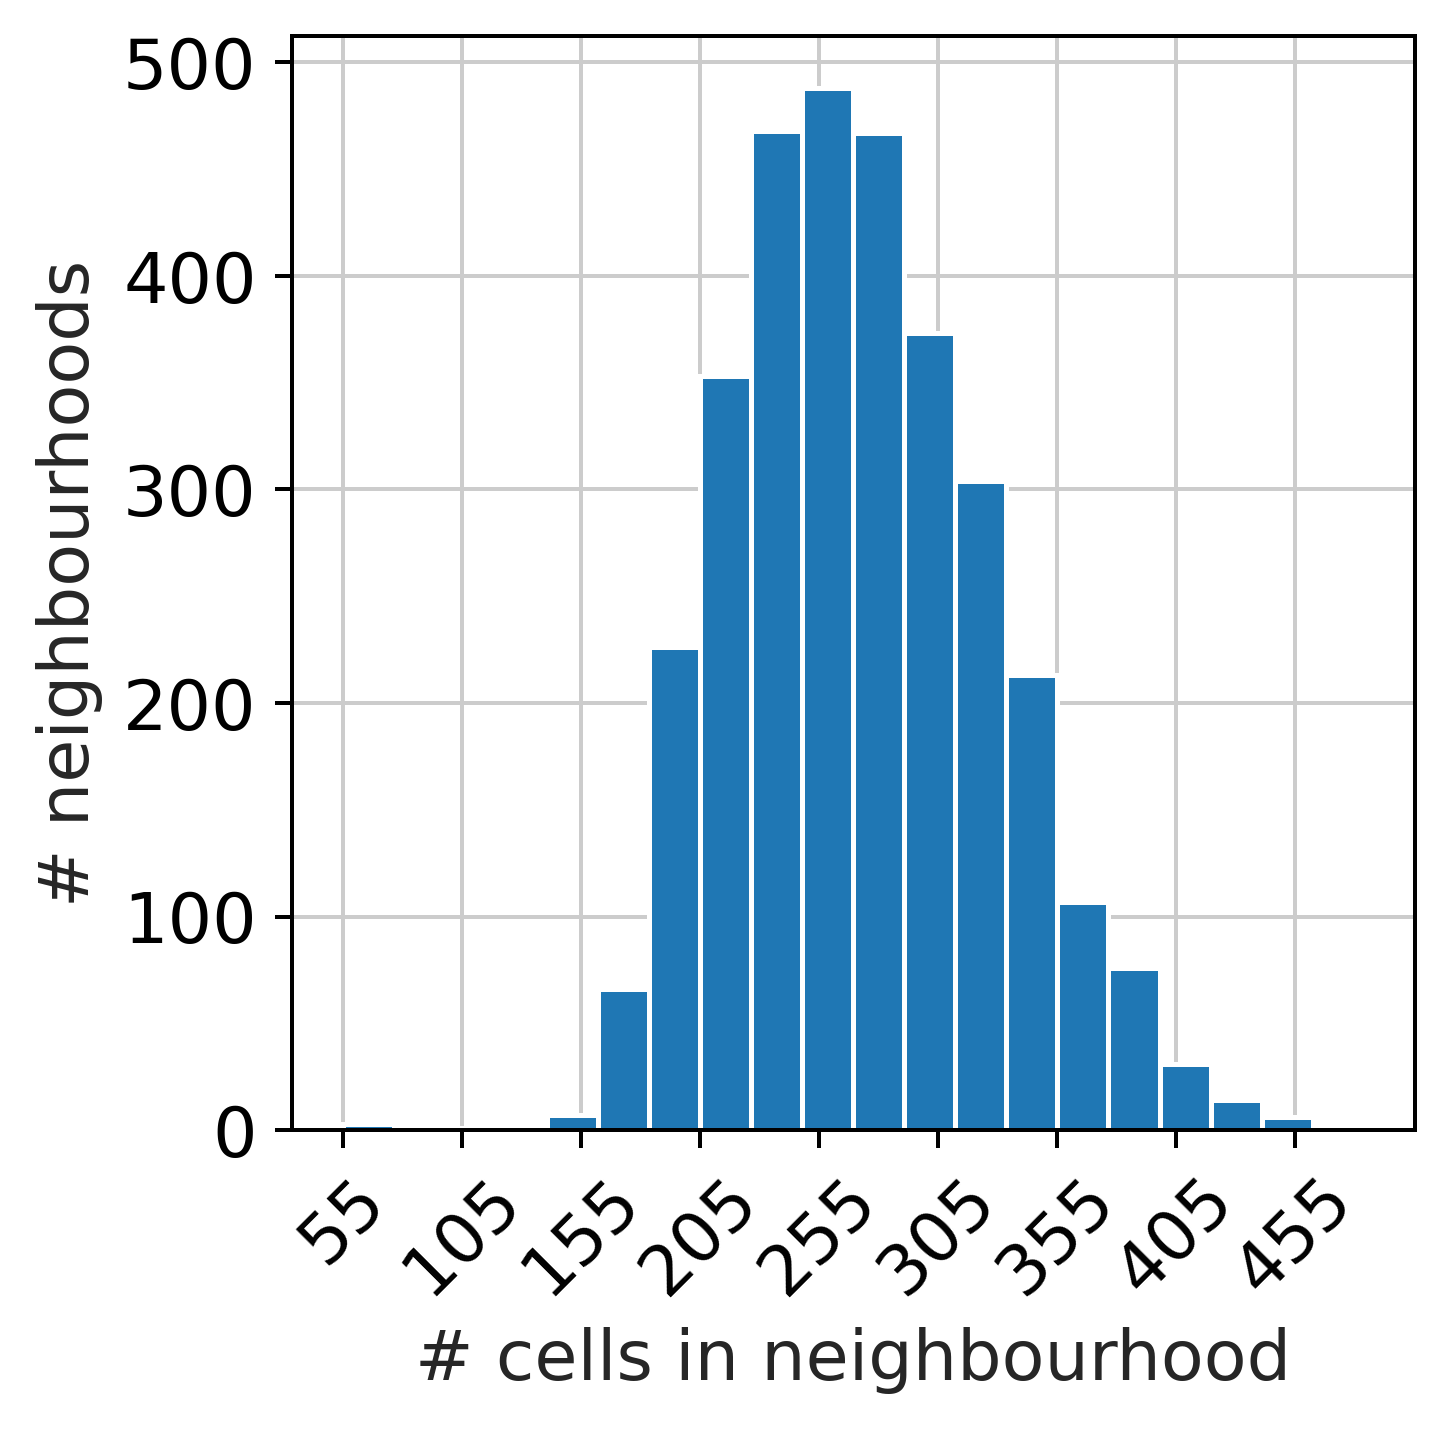

In [29]:
nhood_size = adata.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbourhoods")
plt.xticks(np.arange(min(nhood_size), max(nhood_size) , 50), rotation = 45)

#### Data analysis

1. Neighborhood sizes - 55 cells- 455 cells
2. Symmetric and peak around 200-300 cells indicating that most of cells have 300 cells as neighbors
3. It also has cells more than minimum number of neighborhood cells around 3 * sample number (3 * 6=18) - Proceed for further analysis


### Median neighborhood calculation

In [10]:
np.median(nhood_size)

269.0

## Count cells in Neighborhood

In [11]:
milo.count_nhoods(mdata, sample_col="sample")

/home/skolla/miniforge3/envs/milo/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 41716 × 16060
  2 modalities
    rna:	41716 x 16060
      obs:	'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_types', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'gene_ids-DMD_immune-DMD', 'feature_types-DMD_immune-DMD', 'genome-DMD_immune-DMD', 'mt-DMD_immune-DMD', 'ribo-DMD_immune-DMD', 'n_cells_by_counts-DMD_immune-DMD', 'mean_counts-DMD_immune-DMD', 'pct_dropout_by_counts-DMD_immune-DMD', 'total_counts-DMD_immune-DMD', 'vst.mean-MDX_MPC-DMD', 'vst.variance-MDX_MPC-DMD', 'vst.variance.expected-MDX_MPC-DMD', 'vst.variance.standardized-MDX_MPC-DMD', 'vst.variable-MDX_MPC-DMD', 'vst.mean-MDX_POOL_NEW-DMD', 'vst.variance-MDX_POOL_NEW-DMD', 'vst.variance.expected-MDX_POOL_NEW-DMD', 'vst.variance.standardized-MDX_POOL_NEW-DMD', 'vst.variable-MDX_POOL_NEW-DMD', 'vst.mean-MDX_MPC', 'vst.variance-MDX_MPC', 'vst.variance.expected-MDX_MPC', 'vst.variance.standardized-MDX_MPC', 'vst.variable-MDX_MPC', 'vst.mean-MDX_POOL_NEW', 'vst.variance-MDX_POOL_NEW', 'vst.variance.expected-MDX_POOL_NEW', 'vst.variance.standardized-MDX_POOL_NEW', 'vst.variable-MDX_POOL_NEW', 'name-pbmc_meyer'
      uns:	'C_scANVI_S1_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_source_colors', 'genotype_colors', 'hvg', 'neighbors', 'sample_colors', 'seed_labels_colors', 'umap', 'nhood_neighbors_key'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', 'nhoods'
      obsp:	'distances', 'connectivities'
    milo:	21 x 3206
      var:	'index_cell', 'kth_distance'
      uns:	'sample_col'

## Verifying Neighborhoods

Text(0, 0.5, 'Mean # cells per sample in nhood')

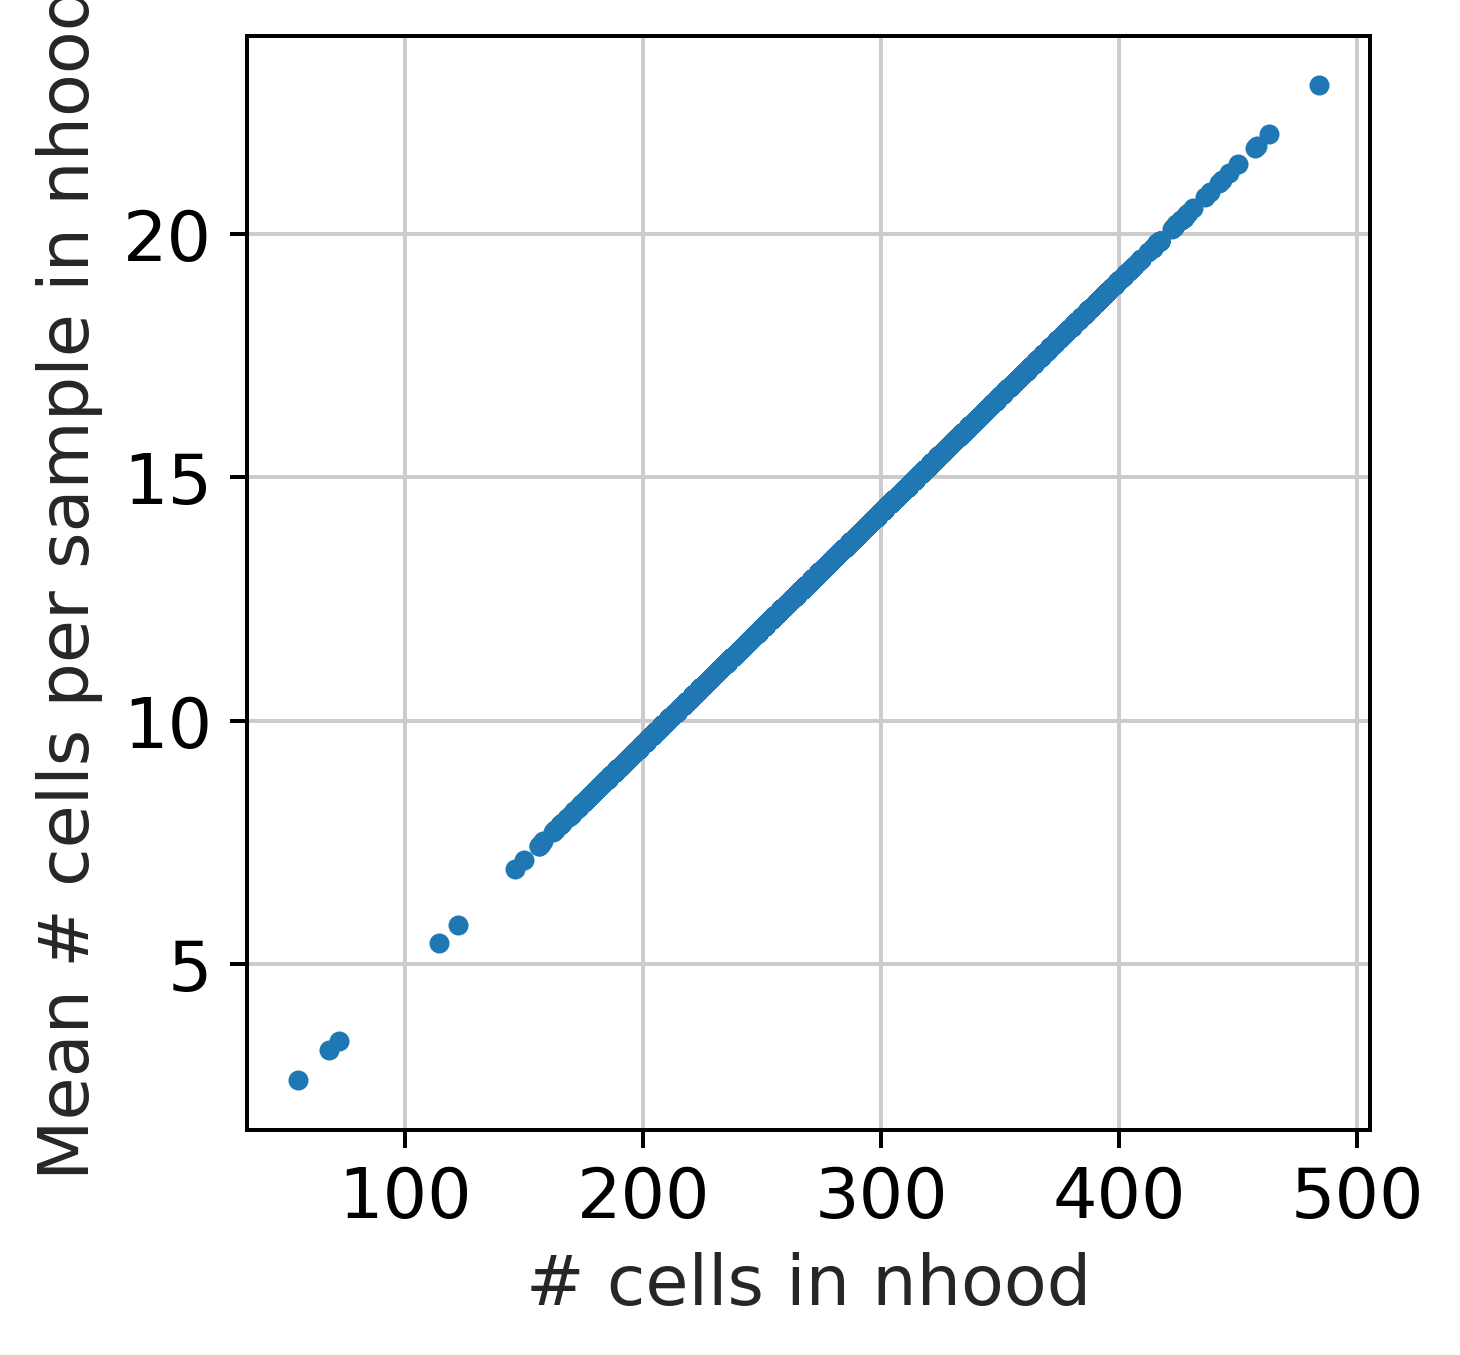

In [12]:
mean_n_cells = mdata["milo"].X.toarray().mean(0)
plt.plot(nhood_size, mean_n_cells, ".")
plt.xlabel("# cells in nhood")
plt.ylabel("Mean # cells per sample in nhood")

#### Data analysis

1. As the number of cells in a neighborhood increases, the mean number of cells per sample in that neighborhood also increases linearly.
2. Uniform distribution - can proceed for downstream analyses

In [13]:
mdata["rna"].obs["genotype"].cat.categories

Index(['Mdx', 'MdxSCID', 'WT'], dtype='object')

## Differential abaundance analysis(DA analysis)

In [14]:
milo.da_nhoods(
    mdata, design="~genotype", model_contrasts="genotypeWT-genotypeMdx"
)

#milo_results_healthy_iav = mdata["milo"].obs.copy()
#milo_results_healthy_iav

/home/skolla/miniforge3/envs/milo/lib/python3.11/site-packages/pertpy/tools/_milo.py:691: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/home/skolla/miniforge3/envs/milo/lib/python3.11/site-packages/pertpy/tools/_milo.py:692: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w = w[keep_nhoods][o]


## Data Diagnostics

#### Steps

1. Define the significance threshold.
2. Set up the plotting environment.
3. Plot a histogram of p-values -Uncorrected.
4. Visualize extent of multiple-testing correction between Uncorrected P-value and SpatialFDR.
5. Volcano plot showing the log-fold change against the negative logarithm of SpatialFDR and null log-fold change.
6. MA plot with mean log-counts and log-fold change.

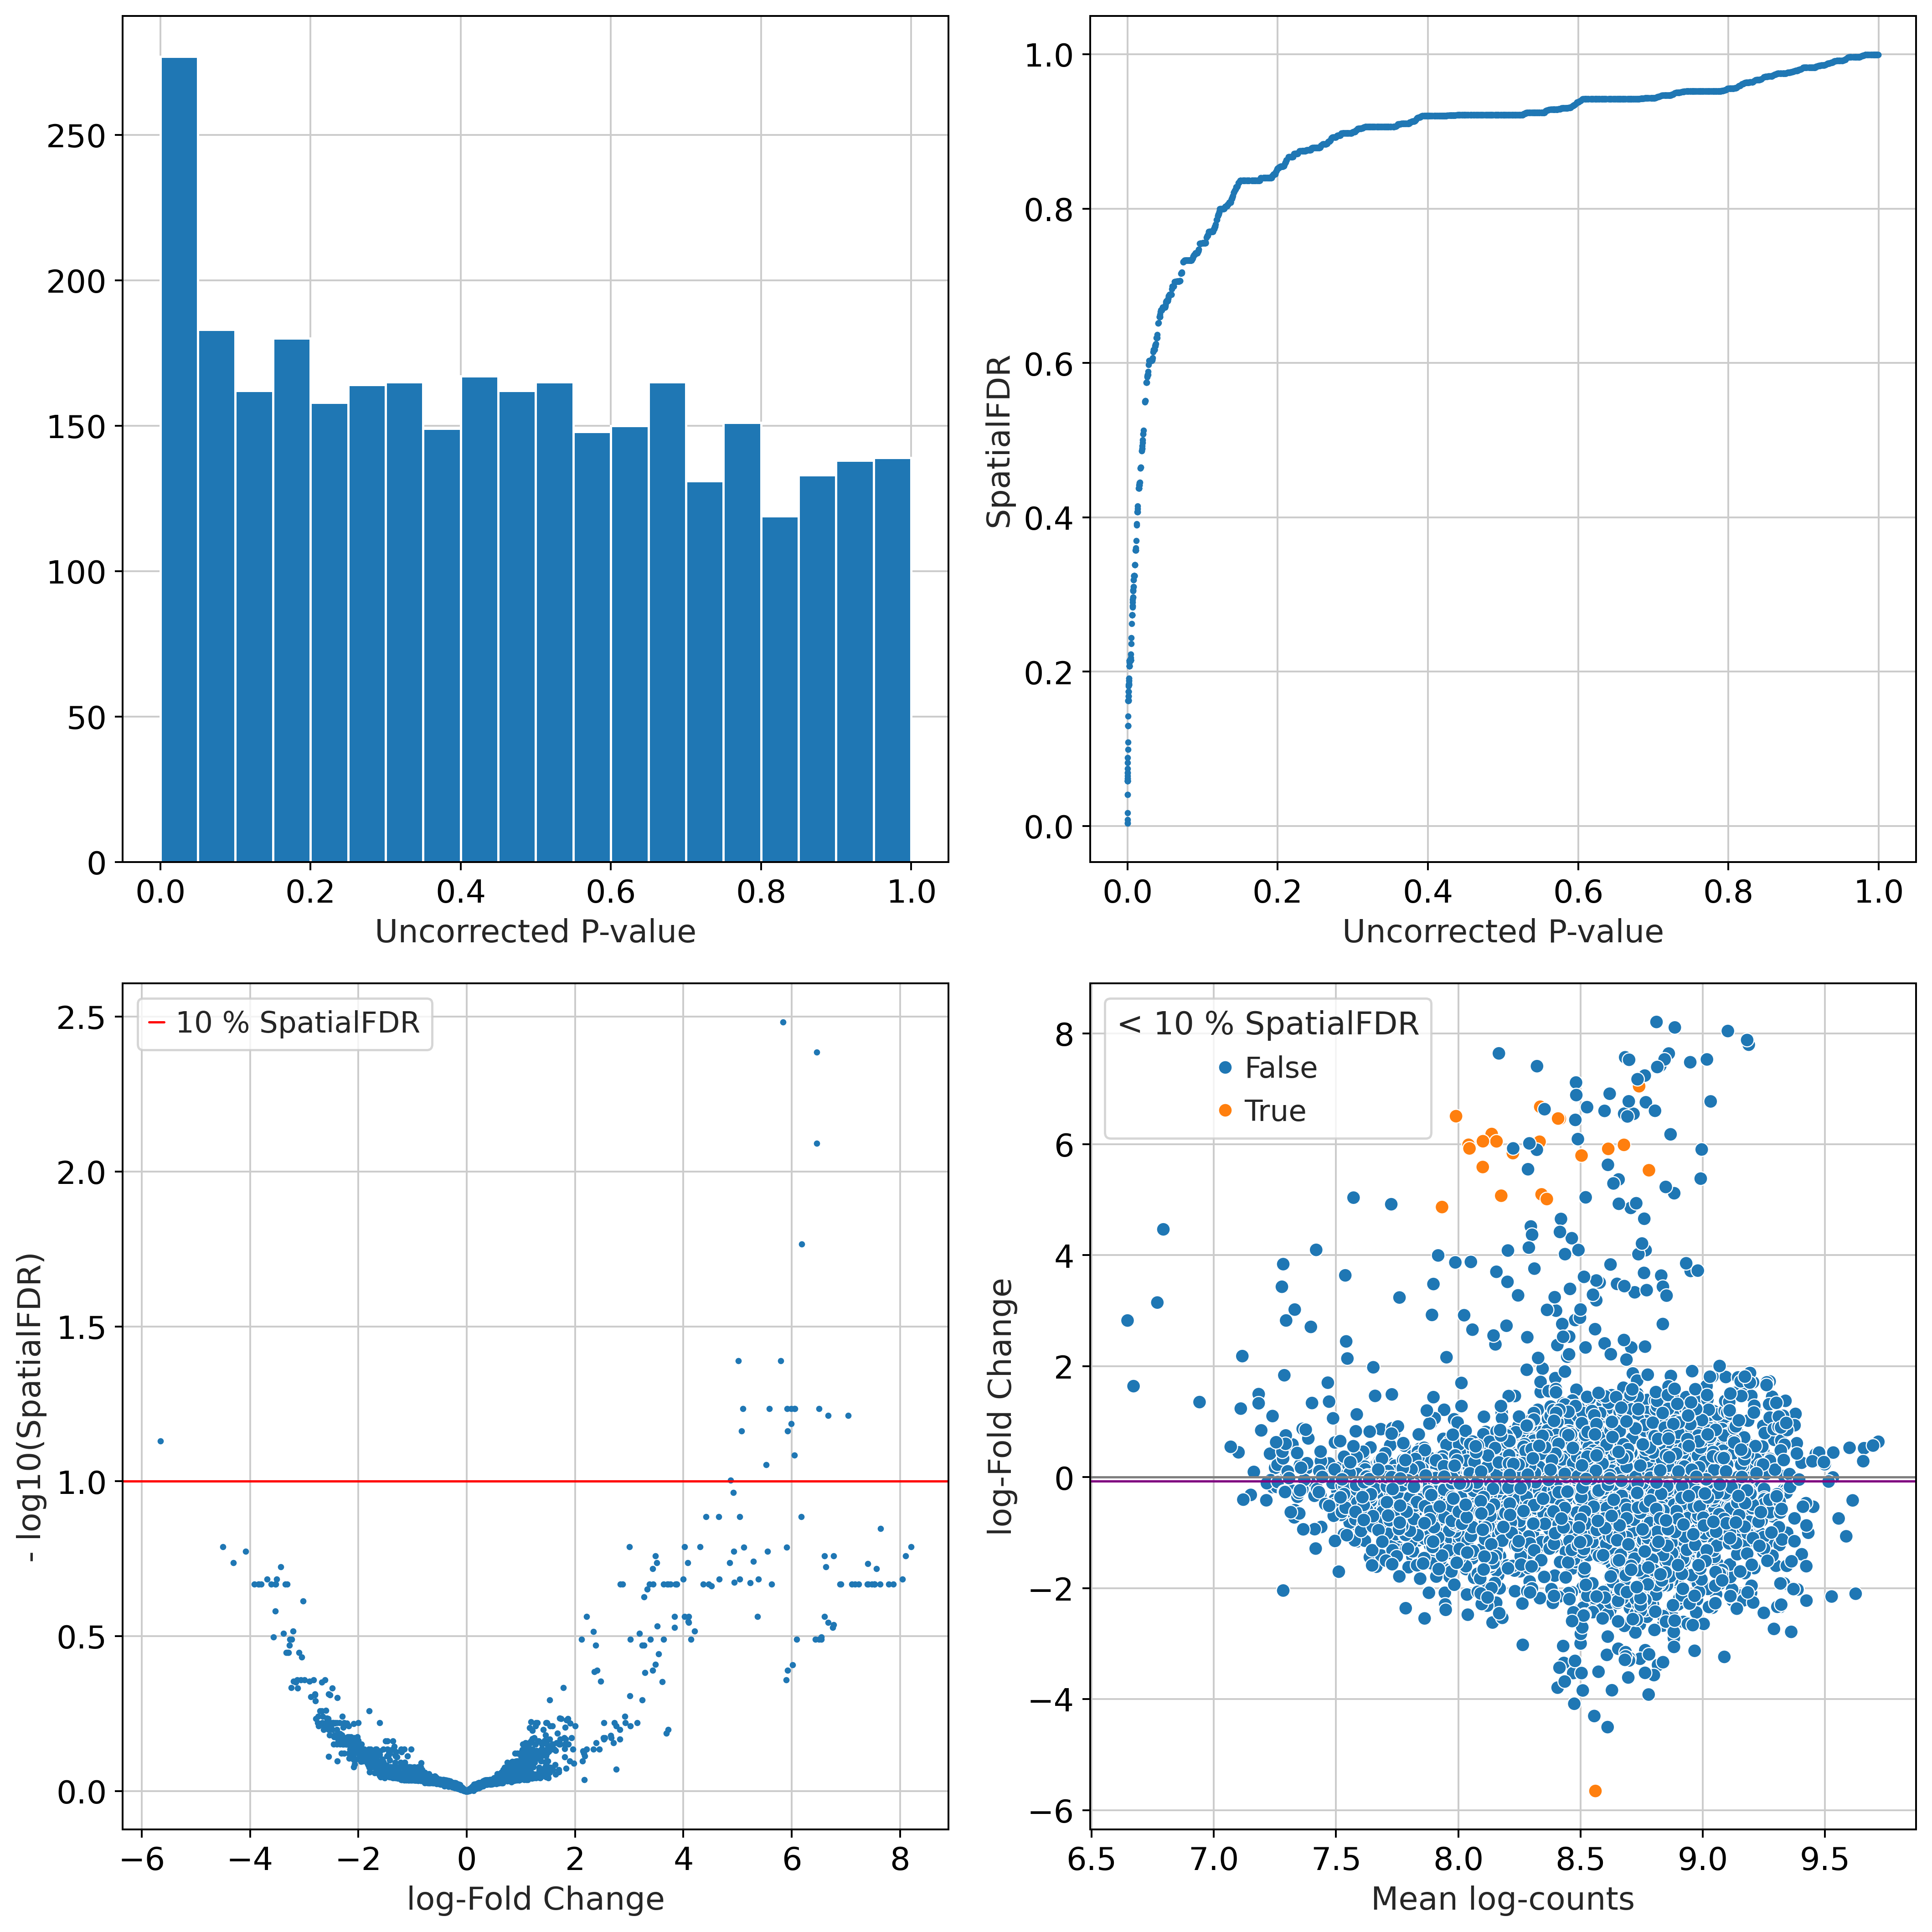

In [15]:
def plot_milo_diagnostics(mdata):
    alpha = 0.1 

    with plt.rc_context({"figure.figsize": [12, 12]}):

        ## P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Scatter plot of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Volcano plot of Spatial FDR
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## MA plot of Spatial FDR
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

#### Data analysis

**P-value histogram**
Helps in assessing the distribution of uncorrected p-values to see if there are any unusual p-values
Potential enrichment at the zero indicating significant neighborhoods

**Scatterplot - Multiple-Testing Correction**
Trend upwards, showing higher SpatialFDR for larger uncorrected p-values

**Volcanoplot**
Helps in identifying significant neighborhoods with significant log-fold changes, aiding in identifying biologically meaningful changes
Red line - significicant threshold
All points above the red line are significant neighborhoods

**MA plot of Spatial FDR**
Helps to identify systematic trends in the data
Significant neighborhoods(True points) are highlighted alkong with Noise(False points)
Purple line showing the empirical null logFC(mean of logfc), helping to identify true biological signals against background noise(insignificant changes)

## Visualization of DA results

In [16]:
mdata

MuData object with n_obs × n_vars = 41716 × 16060
  2 modalities
    rna:	41716 x 16060
      obs:	'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_types', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'gene_ids-DMD_immune-DMD', 'feature_types-DMD_immune-DMD', 'genome-DMD_immune-DMD', 'mt-DMD_immune-DMD', 'ribo-DMD_immune-DMD', 'n_cells_by_counts-DMD_immune-DMD', 'mean_counts-DMD_immune-DMD', 'pct_dropout_by_counts-DMD_immune-DMD', 'total_counts-DMD_immune-DMD', 'vst.mean-MDX_MPC-DMD', 'vst.variance-MDX_MPC-DMD', 'vst.variance.expected-MDX_MPC-DMD', 'vst.variance.standardized-MDX_MPC-DMD', 'vst.variable-MDX_MPC-DMD', 'vst.mean-MDX_POOL_NEW-DMD', 'vst.variance-MDX_POOL_NEW-DMD', 'vst.variance.expected-MDX_POOL_NEW-DMD', 'vst.variance.standardized-MDX_POOL_NEW-DMD', 'vst.variable-MDX_POOL_NEW-DMD', 'vst.mean-MDX_MPC', 'vst.variance-MDX_MPC', 'vst.variance.expected-MDX_MPC', 'vst.variance.standardized-MDX_MPC', 'vst.variable-MDX_MPC', 'vst.mean-MDX_POOL_NEW', 'vst.variance-MDX_POOL_NEW', 'vst.variance.expected-MDX_POOL_NEW', 'vst.variance.standardized-MDX_POOL_NEW', 'vst.variable-MDX_POOL_NEW', 'name-pbmc_meyer'
      uns:	'C_scANVI_S1_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_source_colors', 'genotype_colors', 'hvg', 'neighbors', 'sample_colors', 'seed_labels_colors', 'umap', 'nhood_neighbors_key'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', 'nhoods'
      obsp:	'distances', 'connectivities'
    milo:	21 x 3206
      obs:	'genotype', 'sample'
      var:	'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR', 'Sig'
      uns:	'sample_col'

### Build neighborhood graph

In [17]:
milo.build_nhood_graph(mdata)

### Build neighborhood graph

In [18]:
mdata_milo = mdata.copy()
mdata_milo

MuData object with n_obs × n_vars = 41737 × 19266
  2 modalities
    rna:	41716 x 16060
      obs:	'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_types', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'gene_ids-DMD_immune-DMD', 'feature_types-DMD_immune-DMD', 'genome-DMD_immune-DMD', 'mt-DMD_immune-DMD', 'ribo-DMD_immune-DMD', 'n_cells_by_counts-DMD_immune-DMD', 'mean_counts-DMD_immune-DMD', 'pct_dropout_by_counts-DMD_immune-DMD', 'total_counts-DMD_immune-DMD', 'vst.mean-MDX_MPC-DMD', 'vst.variance-MDX_MPC-DMD', 'vst.variance.expected-MDX_MPC-DMD', 'vst.variance.standardized-MDX_MPC-DMD', 'vst.variable-MDX_MPC-DMD', 'vst.mean-MDX_POOL_NEW-DMD', 'vst.variance-MDX_POOL_NEW-DMD', 'vst.variance.expected-MDX_POOL_NEW-DMD', 'vst.variance.standardized-MDX_POOL_NEW-DMD', 'vst.variable-MDX_POOL_NEW-DMD', 'vst.mean-MDX_MPC', 'vst.variance-MDX_MPC', 'vst.variance.expected-MDX_MPC', 'vst.variance.standardized-MDX_MPC', 'vst.variable-MDX_MPC', 'vst.mean-MDX_POOL_NEW', 'vst.variance-MDX_POOL_NEW', 'vst.variance.expected-MDX_POOL_NEW', 'vst.variance.standardized-MDX_POOL_NEW', 'vst.variable-MDX_POOL_NEW', 'name-pbmc_meyer'
      uns:	'C_scANVI_S1_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_source_colors', 'genotype_colors', 'hvg', 'neighbors', 'sample_colors', 'seed_labels_colors', 'umap', 'nhood_neighbors_key'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', 'nhoods'
      obsp:	'distances', 'connectivities'
    milo:	21 x 3206
      obs:	'genotype', 'sample'
      var:	'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR', 'Sig', 'Nhood_size'
      uns:	'sample_col', 'nhood'
      varm:	'X_milo_graph'
      varp:	'nhood_connectivities'

### Plotting of log fold change in cell compartments

#### Steps

1. Import and Initiate Milo
2. Plot the neighborhood graph
3. Visualize the UMAP

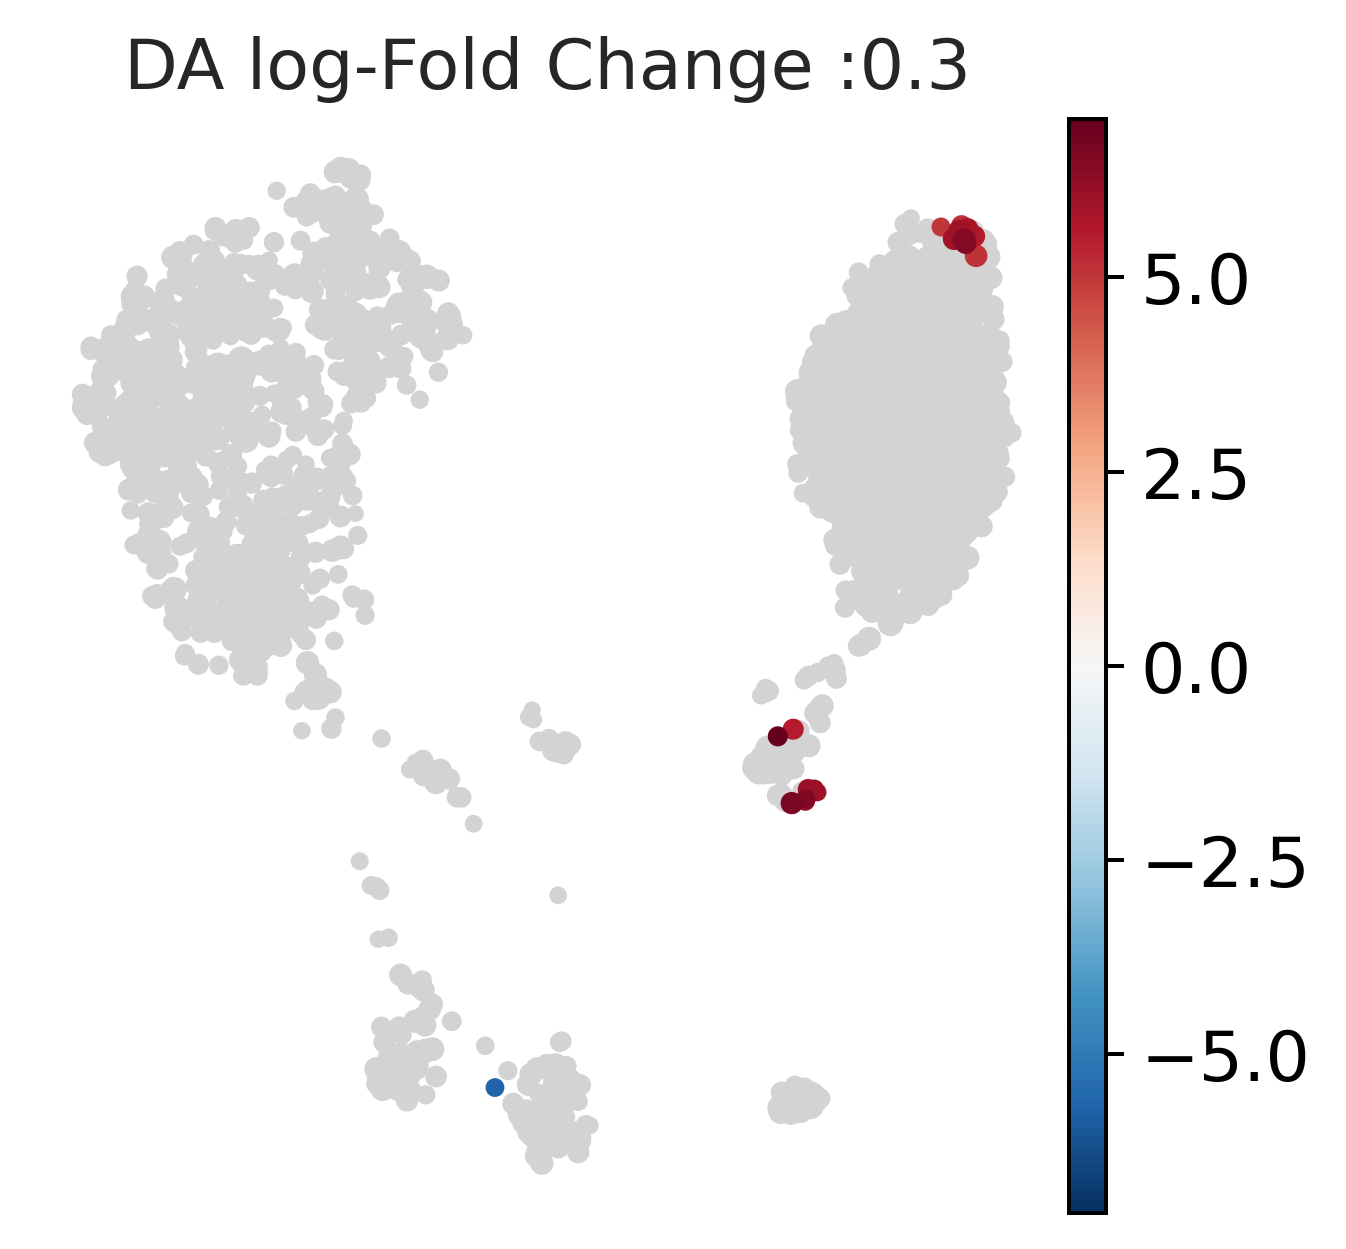

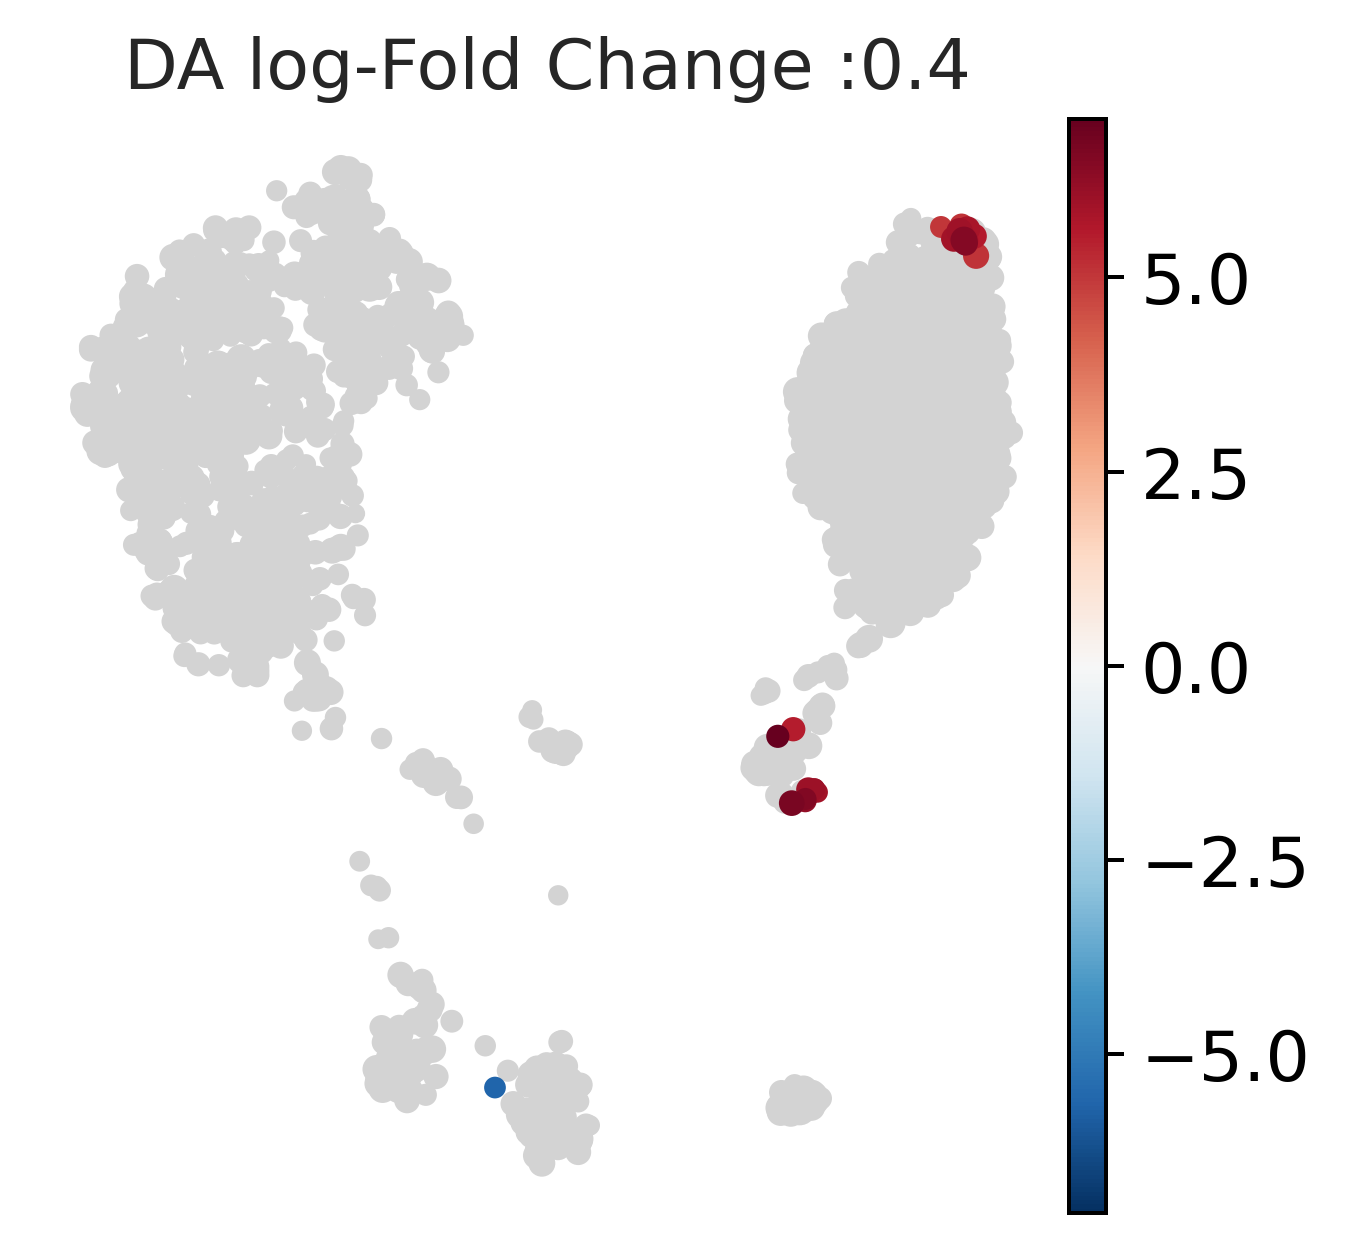

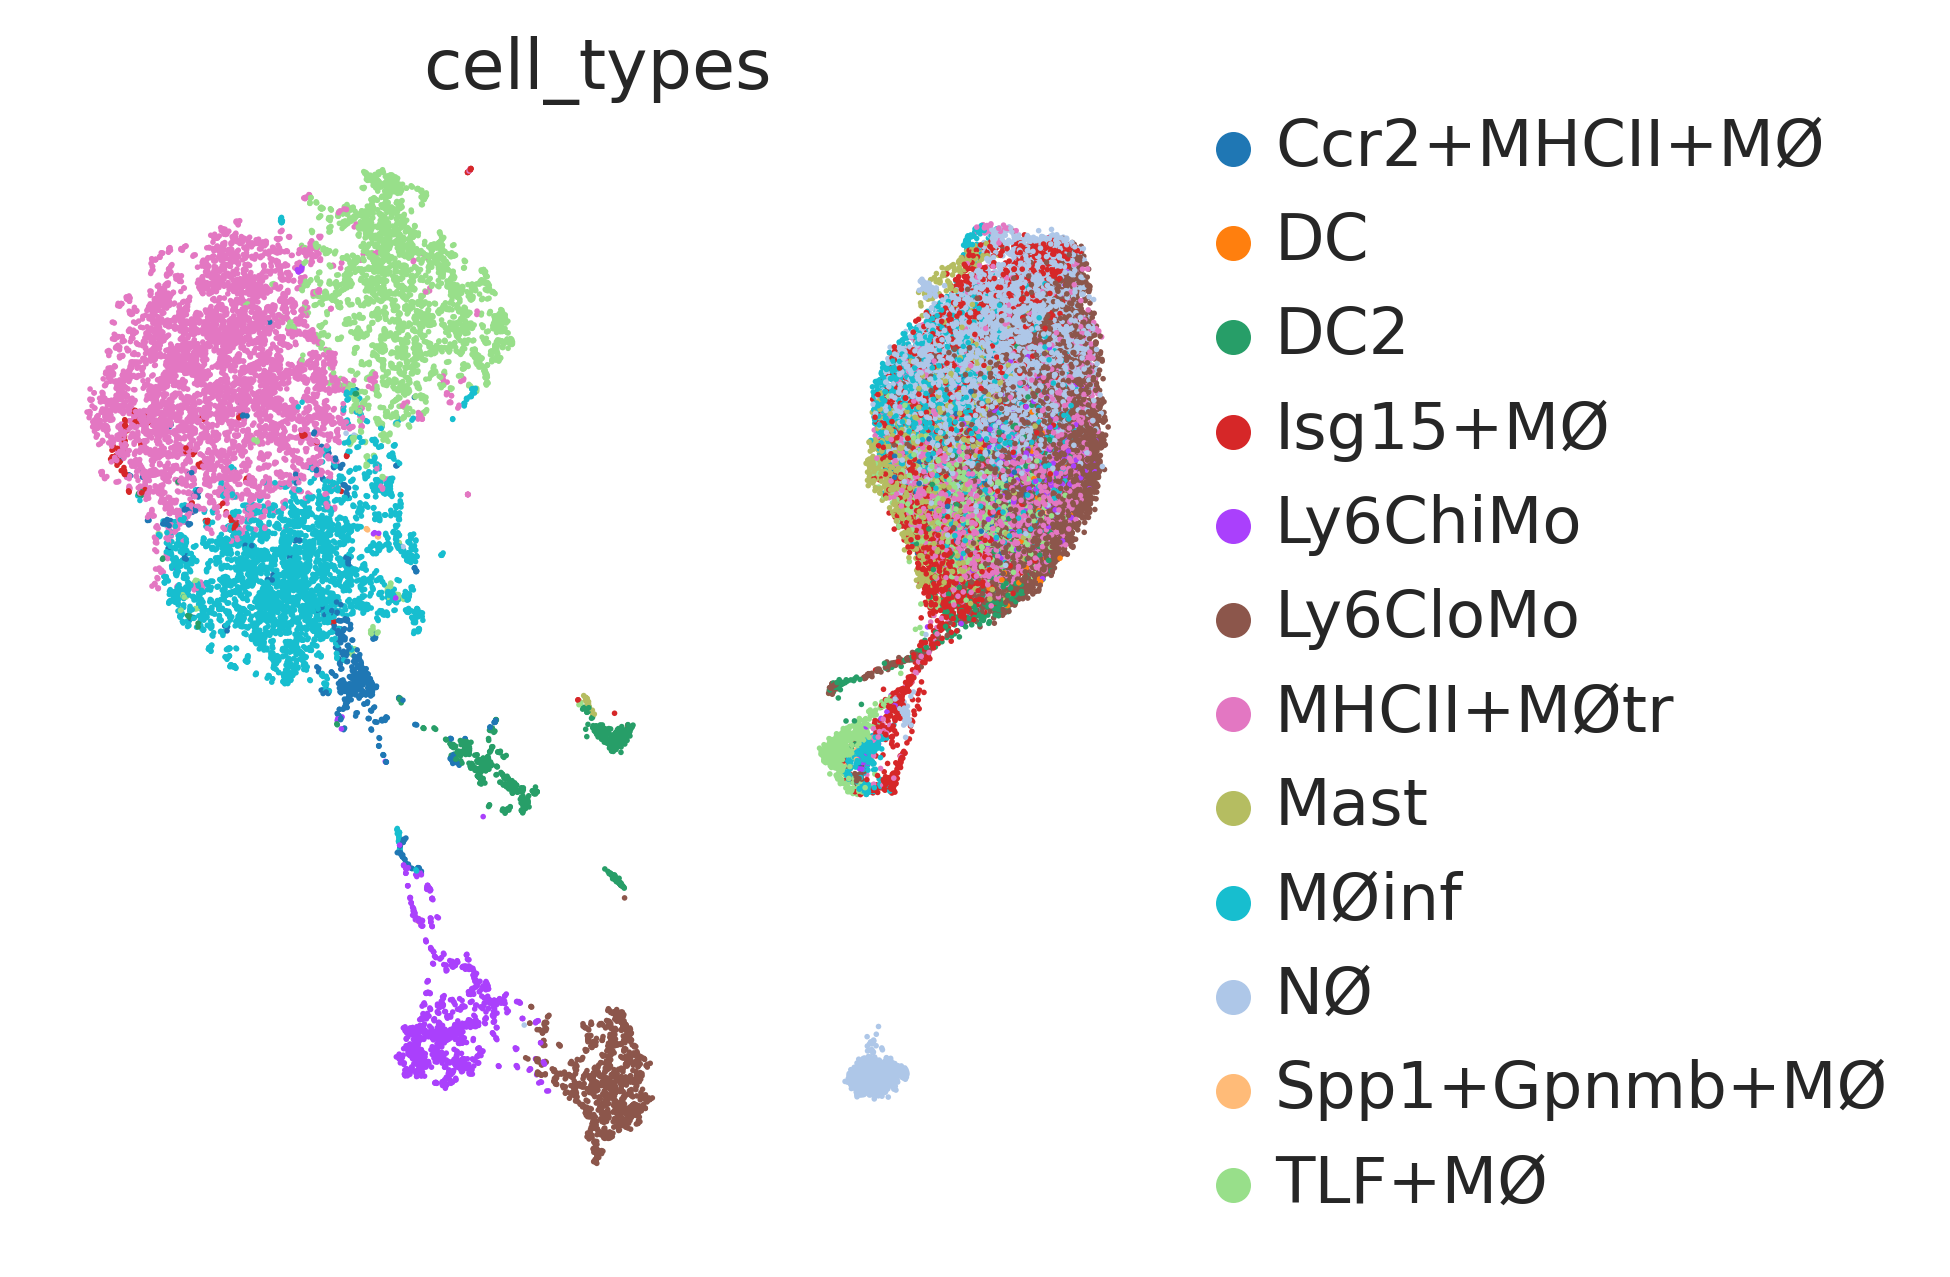

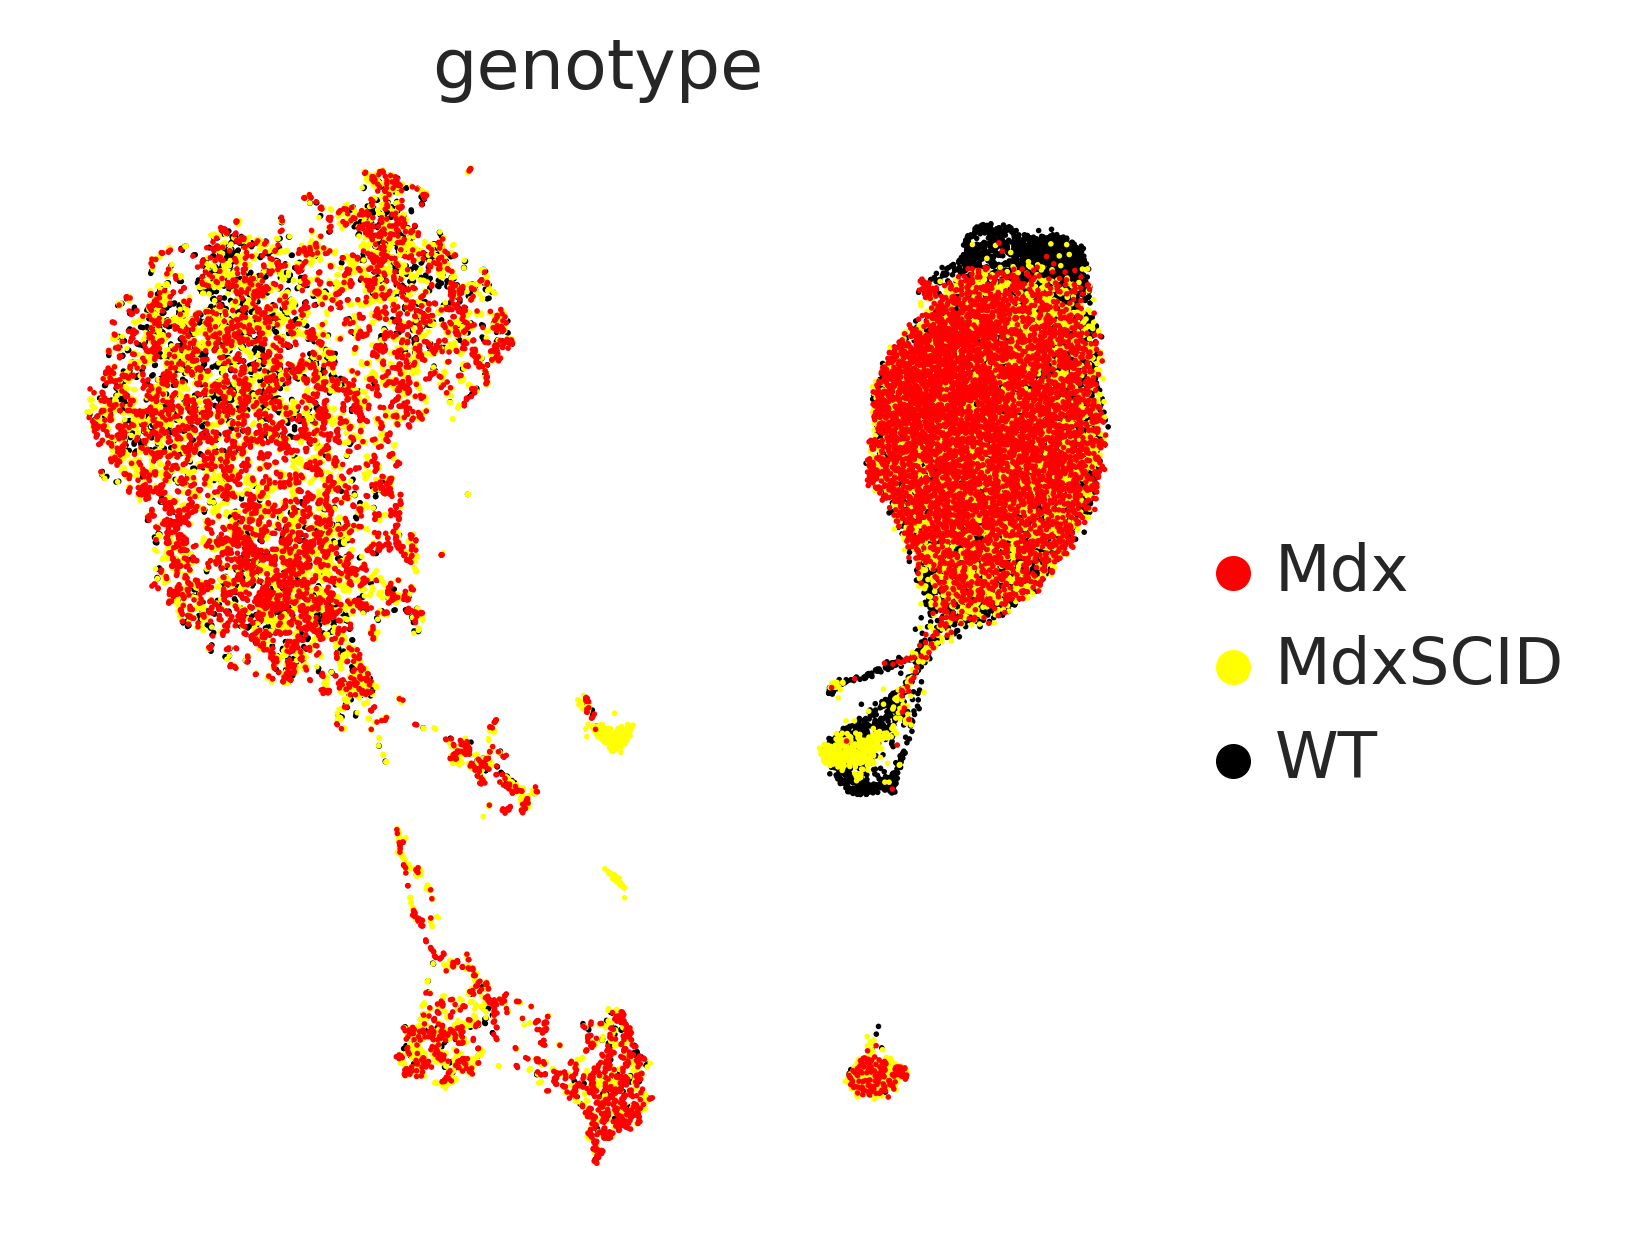

In [19]:
milo = Milo()

with plt.rc_context({"figure.figsize": [4, 4]}):
    milo.plot_nhood_graph(mdata, alpha=0.1, min_size=0.3, plot_edges=False, title = 'DA log-Fold Change :0.3')
    milo.plot_nhood_graph(mdata, alpha=0.1, min_size=0.4, plot_edges=False,title = 'DA log-Fold Change :0.4')
    sc.pl.umap(mdata["rna"], color="cell_types", frameon=False, size=5)
    sc.pl.umap(mdata["rna"], color="genotype",  frameon=False, size=5)

## Neighborhood Annotation

In [20]:
milo.annotate_nhoods(mdata, anno_col="cell_types")

In [21]:
adata.obs['cell_types'].cat.categories

Index(['Ccr2+MHCII+MØ', 'DC', 'DC2', 'Isg15+MØ', 'Ly6ChiMo', 'Ly6CloMo',
       'MHCII+MØtr', 'Mast', 'MØinf', 'NØ', 'Spp1+Gpnmb+MØ', 'TLF+MØ'],
      dtype='object')

#### Steps

1. Define groups 
2. Create subplots
3. Plot each histogram of log-fold changes for neighborhoods annotated 

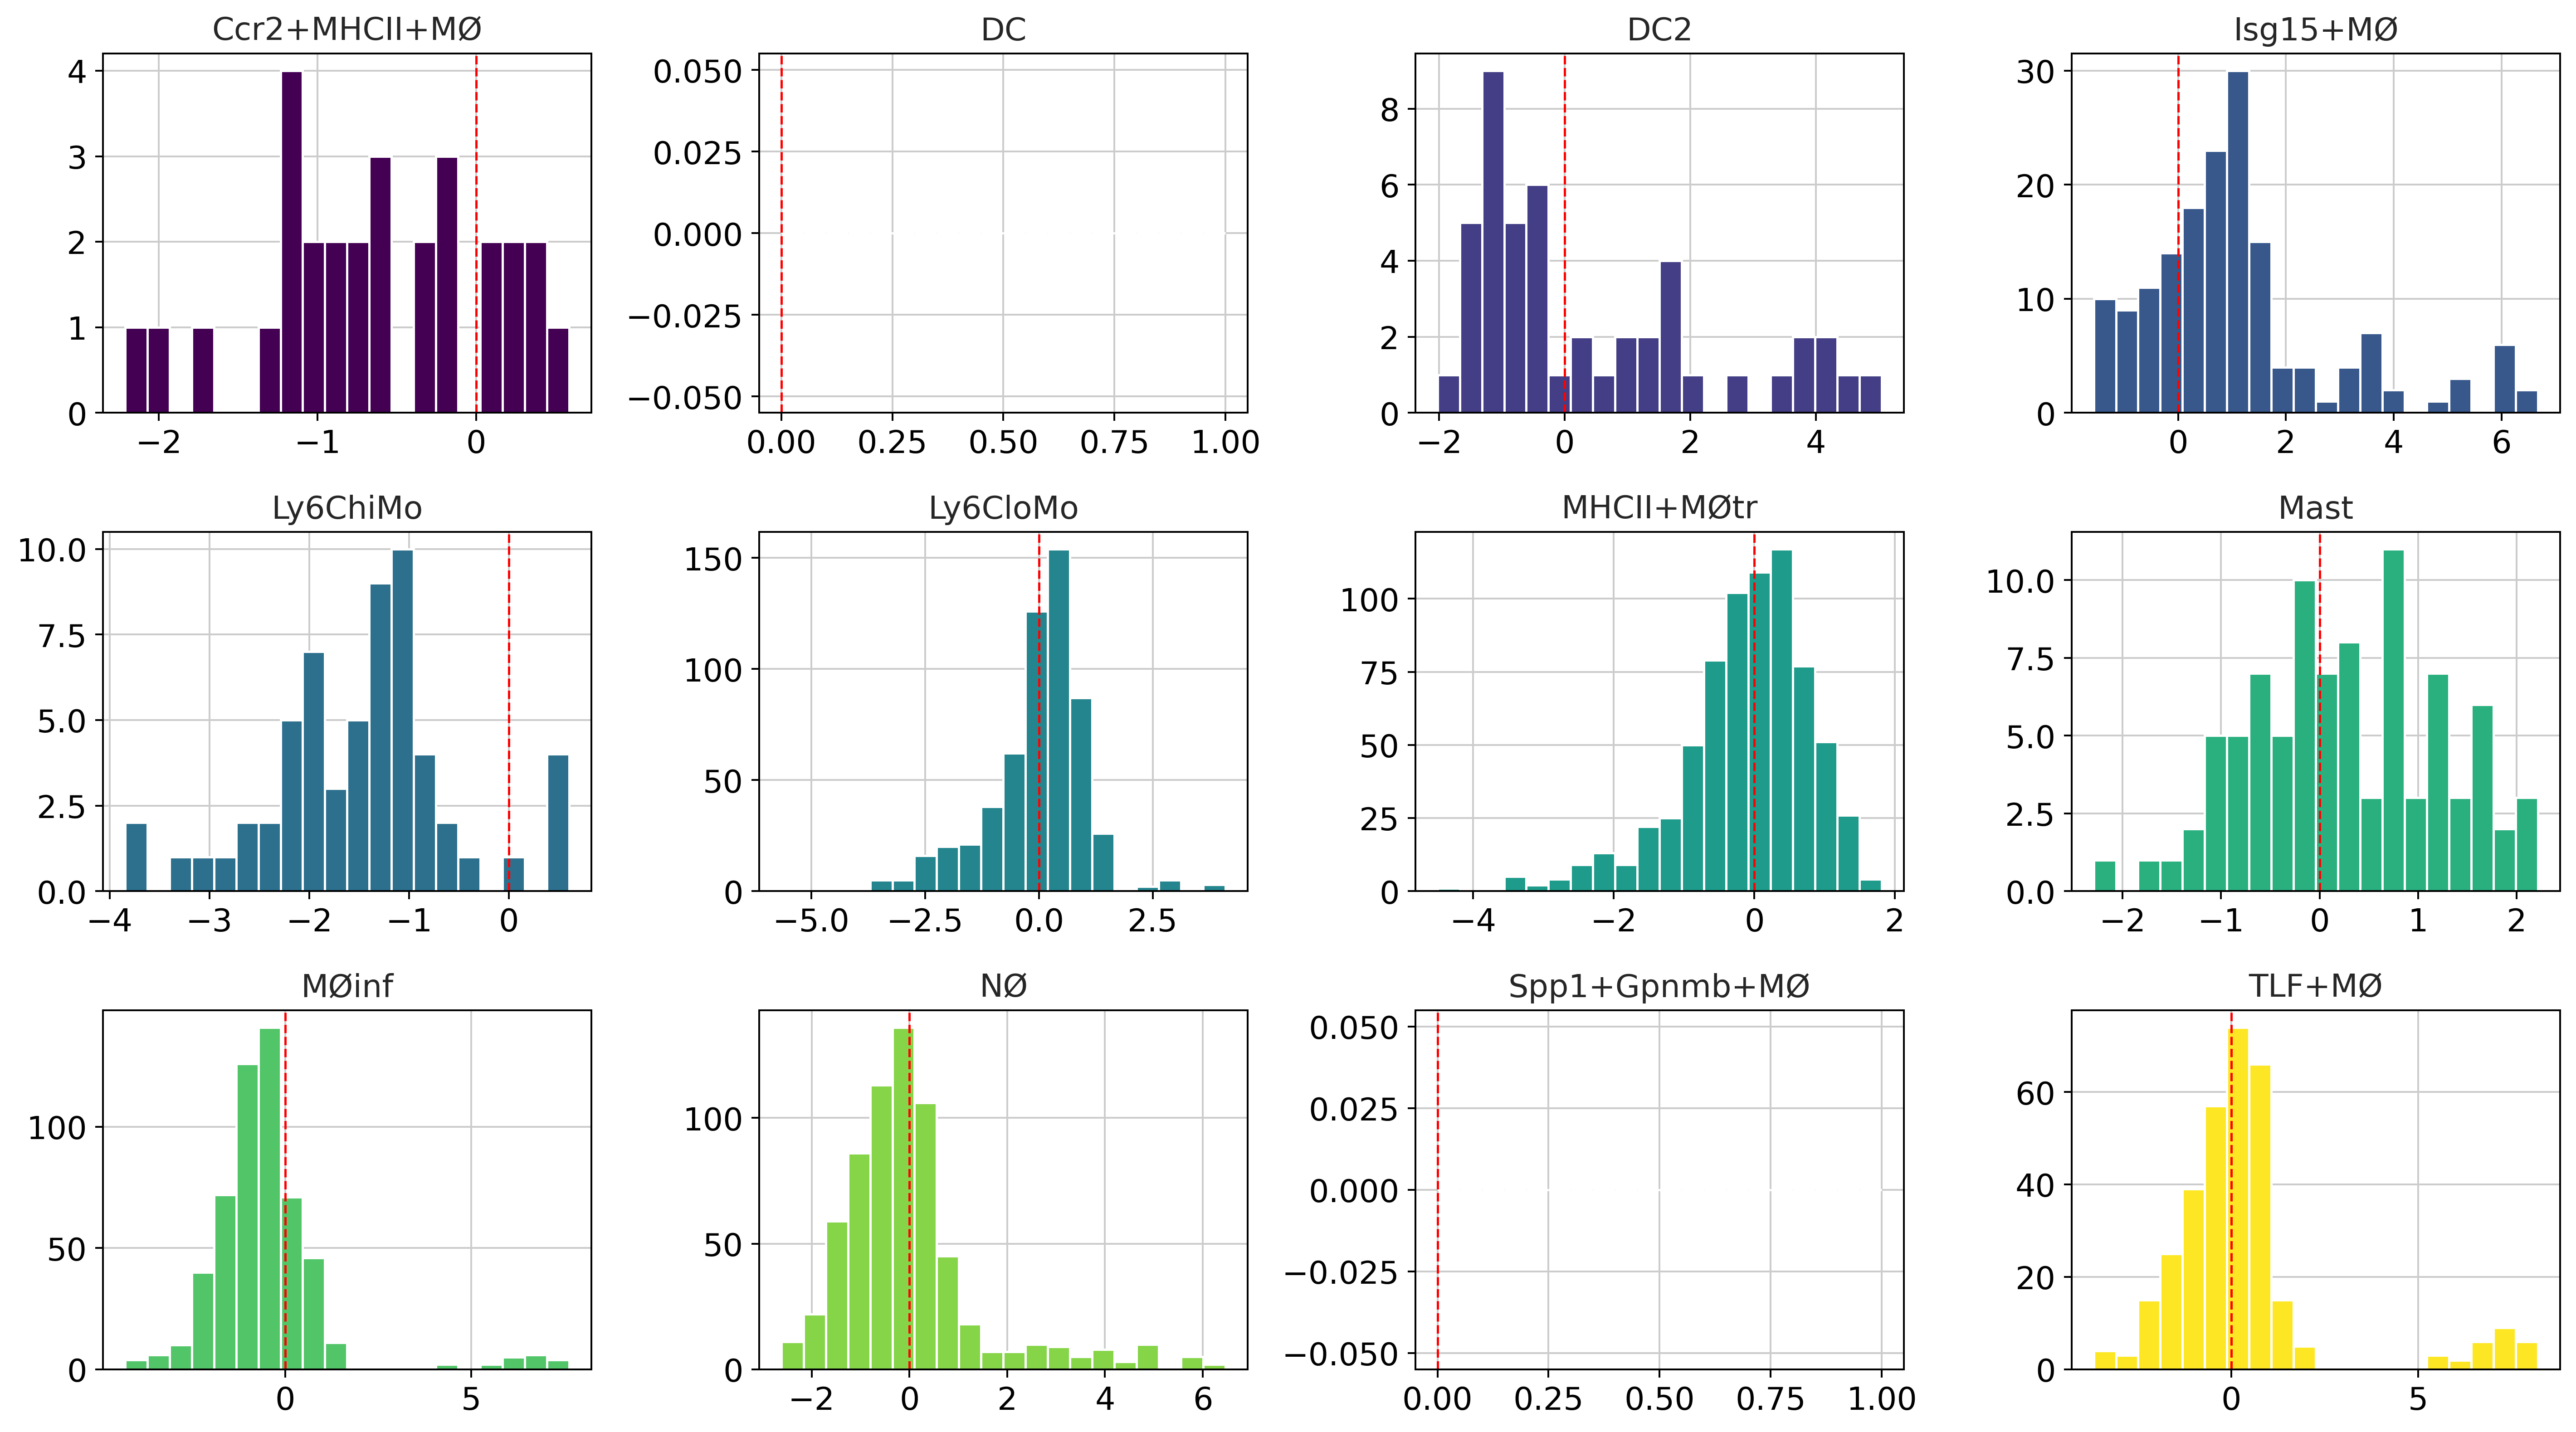

In [22]:
groups = ['Ccr2+MHCII+MØ', 'DC', 'DC2', 'Isg15+MØ', 'Ly6ChiMo', 'Ly6CloMo',
          'MHCII+MØtr', 'Mast', 'MØinf', 'NØ', 'Spp1+Gpnmb+MØ', 'TLF+MØ']

num_rows = 3
num_cols = 4

fig, axs = plt.subplots(num_rows, num_cols, sharey=False, sharex=False, tight_layout=True, figsize=(16, 9))

colors = plt.cm.viridis(np.linspace(0, 1, len(groups)))

for i, group in enumerate(groups):
    row = i // num_cols
    col = i % num_cols
    
    axs[row, col].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin([group])]["logFC"], bins=20, color=colors[i])
    axs[row, col].axvline(x=0, color='r', linewidth=1, linestyle='--')
    axs[row, col].set_title(group)

plt.tight_layout()

#### Data analysis

1. Each histogram shows the Cell Type Abundance and Differential Expression. 
2. Helps in understanding the distribution of gene expression changes
        centered around zero - No significant change 
        skewed towards positive - Upregulated
        skewed towards positive - Downregulated
3. Red line - reference 
4. Helps in understanding the cell type abundance
        Less abundance - Less bars
        More abundance - More bars

## Significance ratios

#### Steps

1. Create a new dictionary
2. Make a loop to iterate on all Cell Compartments
3. Start significant and insignificant counts
4. Iterate over neighborhoods in milo object and add counting for significant and insignificant
5. Calculate significance ration
6. Make a dataframe from dictionary with significance ratio for each cell

Helps in visualization of significant cell proportions in each cell compartment

In [23]:
def significance_ratios(mdata_object):
    d = {"cell_compartments": [], "significance_ratio": []}
    for i in mdata_object["milo"].var["nhood_annotation"].unique():
        significant = 0
        insignificant = 0
        d["cell_compartments"].append(i)
        for j in mdata_object["milo"].var[mdata_object["milo"].var["nhood_annotation"].isin([i])]["Sig"]:
            if j == True:
                significant += 1
            else:
                insignificant += 1
        d["significance_ratio"].append(significant/(significant+insignificant))
    df = pd.DataFrame.from_dict(data=d)
    return df

In [24]:
mdata['rna'].obs.head()

orig.ident Age_group  BMI COVID_severity  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   

                                  COVID_status Ethnicity Group  Sex  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   

                                  annotation_broad annotation_detailed  ...  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW              NaN                 NaN  ...   

                                  XIST-counts S_score G2M_score _scvi_batch  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW         NaN     NaN       NaN        28.0   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW         NaN     NaN       NaN        29.0   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW         NaN     NaN       NaN        30.0   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW         NaN     NaN       NaN        27.0   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW         NaN     NaN       NaN        31.0   

                                  _scvi_labels MPC_Annotation compartment  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW         34.0            NaN         DMD   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW         34.0            NaN         DMD   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW         34.0            NaN         DMD   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW         34.0            NaN         DMD   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW         34.0            NaN         DMD   

                                   nhood_ixs_random  nhood_ixs_refined  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW                 0                  0   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW                 0                  0   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW                 0                  0   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW                 0                  0   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW                 1                  0   

                                  nhood_kth_distance  
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW                0.0  
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW                0.0  
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW                0.0  
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW                0.0  
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW                0.0  

[5 rows x 49 columns]

In [25]:
significance = significance_ratios(mdata)
significance

cell_compartments  significance_ratio
0            TLF+MØ            0.006079
1                NØ            0.016616
2          Isg15+MØ            0.048780
3              Mast            0.000000
4          Ly6CloMo            0.001745
5               DC2            0.000000
6             MØinf            0.000000
7          Ly6ChiMo            0.000000
8        MHCII+MØtr            0.000000
9     Ccr2+MHCII+MØ            0.000000

### Plotting significance ratios

#### Steps

1. Select an order for visualization
2. Set parameters for subplots
3. Plot boxplot - Log FC vs neighborhoods
4. Plot barplot - Significance ratio and cell compartments

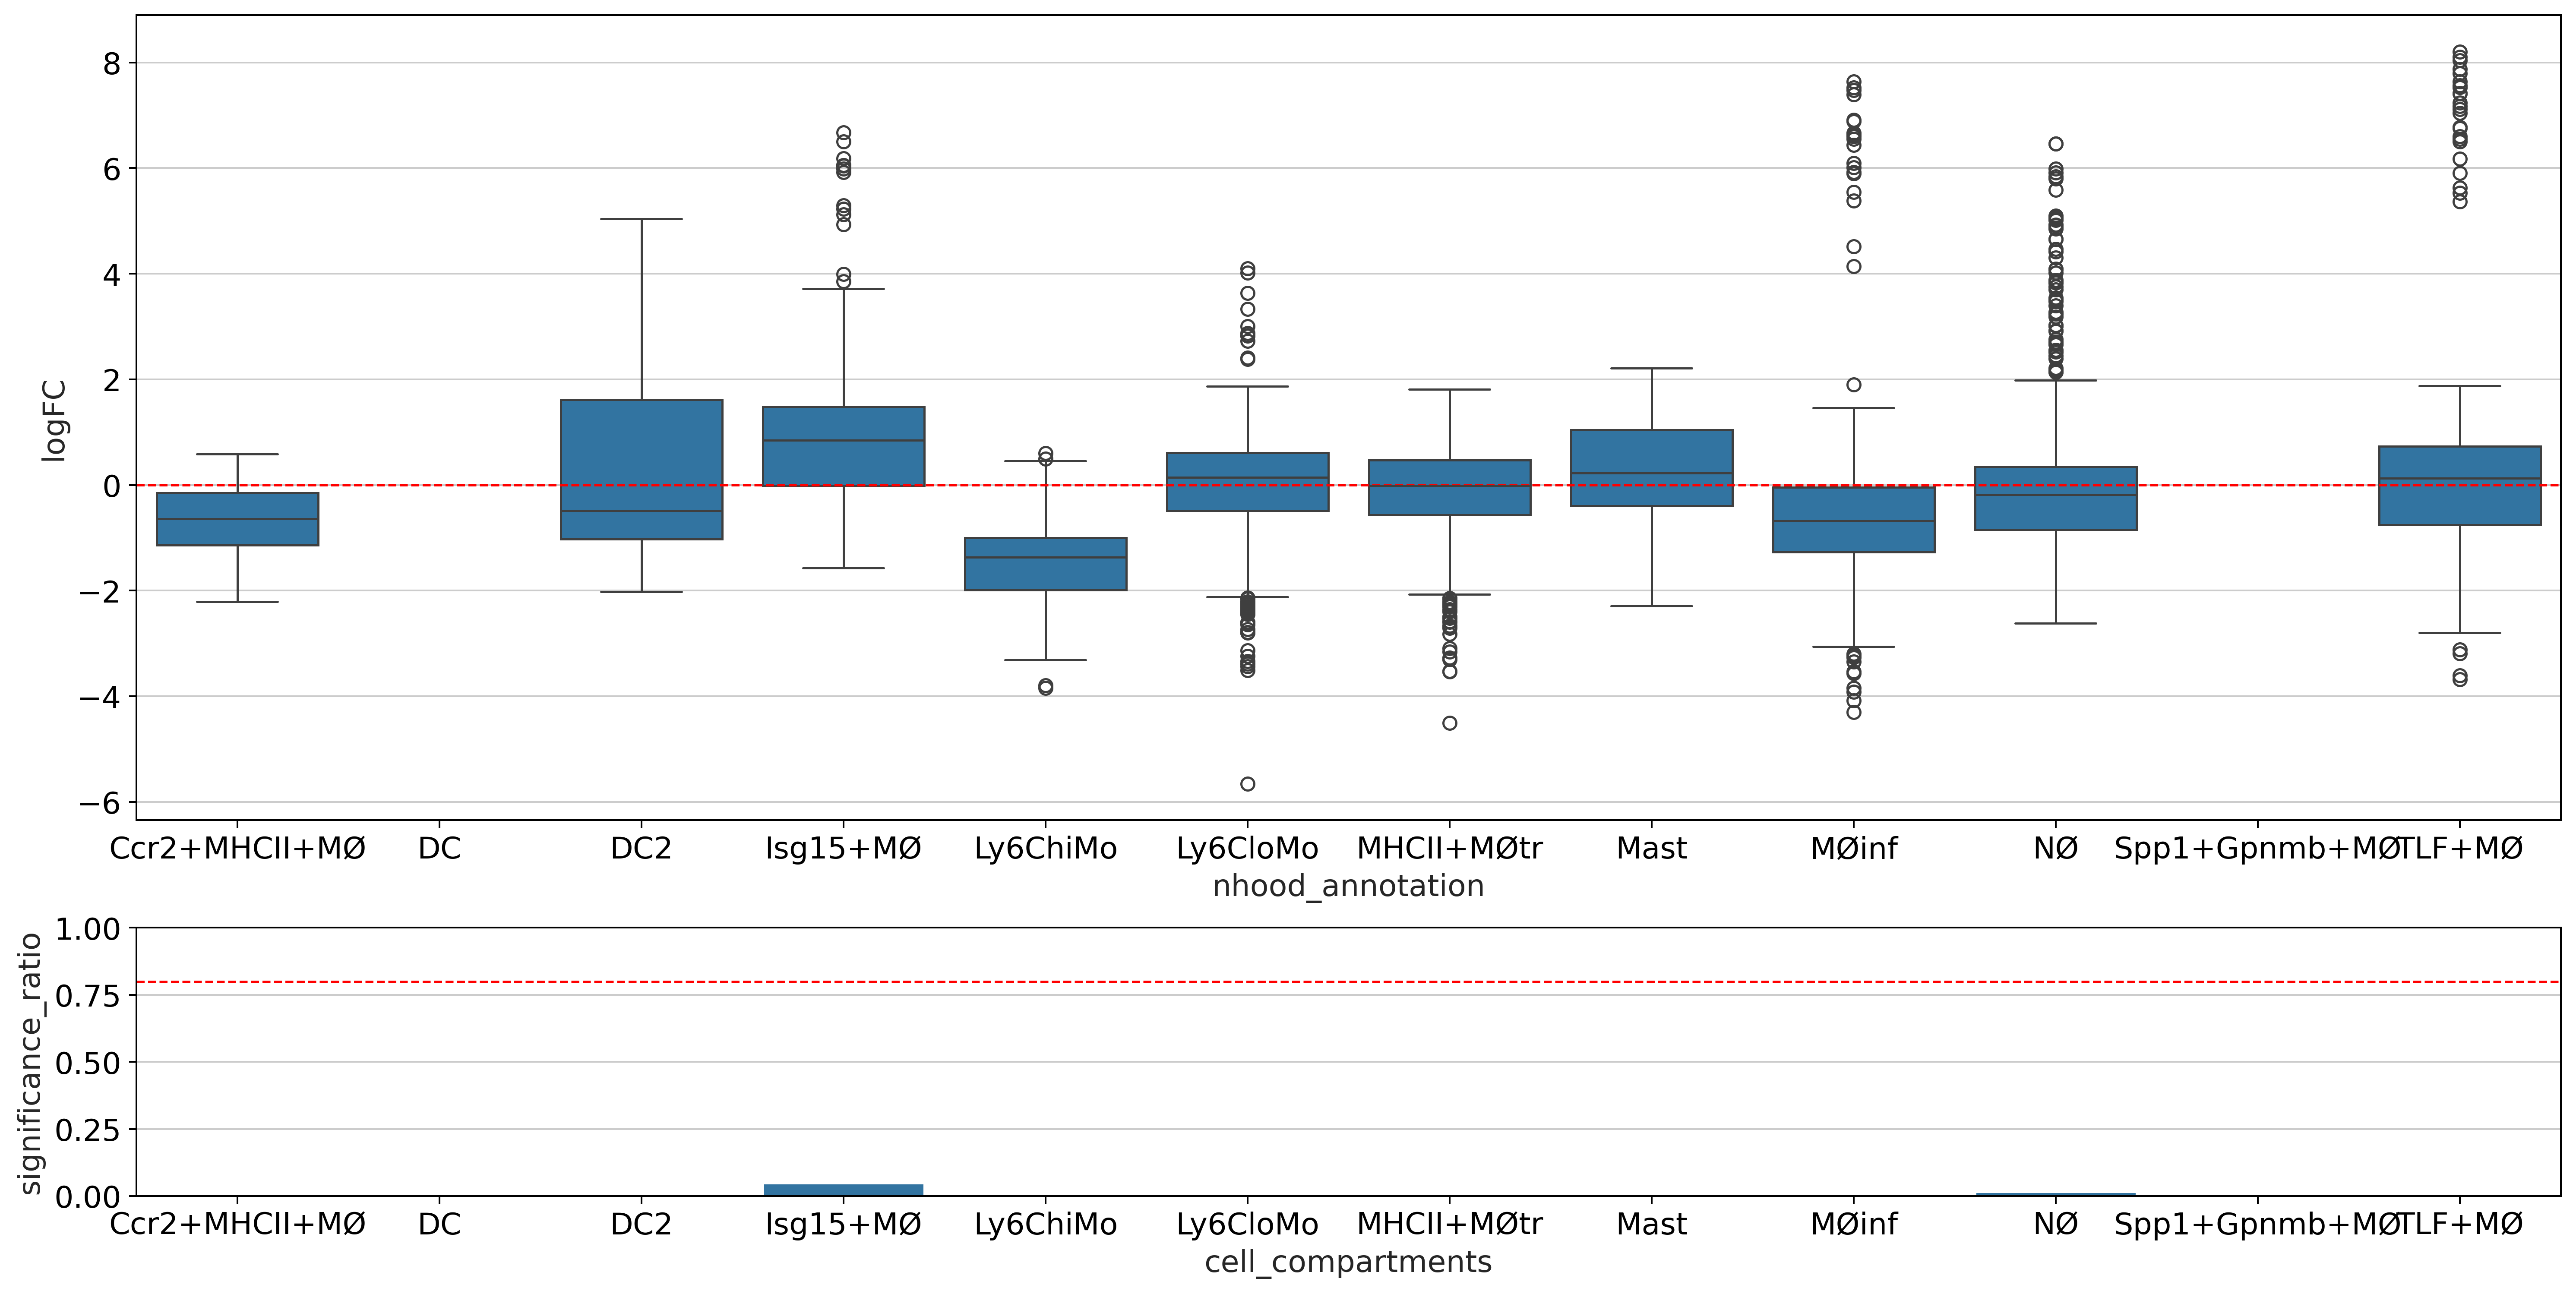

In [26]:
order = ['Ccr2+MHCII+MØ', 'DC', 'DC2', 'Isg15+MØ', 'Ly6ChiMo', 'Ly6CloMo',
          'MHCII+MØtr', 'Mast', 'MØinf', 'NØ', 'Spp1+Gpnmb+MØ', 'TLF+MØ']
fig, axs = plt.subplots(2, figsize=(20,10), gridspec_kw={'height_ratios': [3, 1]})
sns.boxplot(data=mdata["milo"].var, x="nhood_annotation", y="logFC", order=order, ax=axs[0])
axs[0].axhline(y=0, color='r', linewidth=1, linestyle='--')
sns.barplot(data=significance, x="cell_compartments", y="significance_ratio", order=order, ax=axs[1])
plt.ylim(0, 1)
axs[1].axhline(y=0.8, color='r', linewidth=1, linestyle='--')

#### Data analysis

Median Line for logFC - Above 0 - Upregulation, Below 0 - Downregulation 


Box Edges: - 25 and 75 quartiles


Whiskers - 1.5 times the IQR from the quartiles


Red line - No significant change

In [27]:
mdata


MuData object with n_obs × n_vars = 41716 × 16060
  2 modalities
    rna:	41716 x 16060
      obs:	'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_types', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'gene_ids-DMD_immune-DMD', 'feature_types-DMD_immune-DMD', 'genome-DMD_immune-DMD', 'mt-DMD_immune-DMD', 'ribo-DMD_immune-DMD', 'n_cells_by_counts-DMD_immune-DMD', 'mean_counts-DMD_immune-DMD', 'pct_dropout_by_counts-DMD_immune-DMD', 'total_counts-DMD_immune-DMD', 'vst.mean-MDX_MPC-DMD', 'vst.variance-MDX_MPC-DMD', 'vst.variance.expected-MDX_MPC-DMD', 'vst.variance.standardized-MDX_MPC-DMD', 'vst.variable-MDX_MPC-DMD', 'vst.mean-MDX_POOL_NEW-DMD', 'vst.variance-MDX_POOL_NEW-DMD', 'vst.variance.expected-MDX_POOL_NEW-DMD', 'vst.variance.standardized-MDX_POOL_NEW-DMD', 'vst.variable-MDX_POOL_NEW-DMD', 'vst.mean-MDX_MPC', 'vst.variance-MDX_MPC', 'vst.variance.expected-MDX_MPC', 'vst.variance.standardized-MDX_MPC', 'vst.variable-MDX_MPC', 'vst.mean-MDX_POOL_NEW', 'vst.variance-MDX_POOL_NEW', 'vst.variance.expected-MDX_POOL_NEW', 'vst.variance.standardized-MDX_POOL_NEW', 'vst.variable-MDX_POOL_NEW', 'name-pbmc_meyer'
      uns:	'C_scANVI_S1_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_source_colors', 'genotype_colors', 'hvg', 'neighbors', 'sample_colors', 'seed_labels_colors', 'umap', 'nhood_neighbors_key', 'cell_types_colors'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', 'nhoods'
      obsp:	'distances', 'connectivities'
    milo:	21 x 3206
      obs:	'genotype', 'sample'
      var:	'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR', 'Sig', 'Nhood_size', 'nhood_annotation', 'nhood_annotation_frac'
      uns:	'sample_col', 'nhood', 'annotation_labels', 'annotation_obs'
      varm:	'X_milo_graph', 'frac_annotation'
      varp:	'nhood_connectivities'